# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler
from torch.optim import lr_scheduler
from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [29]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [30]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [31]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [12]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [13]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, scheduler, num_epochs):
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        scheduler.step()
        model.train() # Enter train mode
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(loader):
        prediction = model(x)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]

    train_accuracy = float(correct_samples) / total_samples
    return train_accuracy

#loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [7]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
        Flattener(),
        nn.Linear(3*32*32, 100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 10)
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

TypeError: train_model() missing 1 required positional argument: 'num_epochs'

Добавьте слой с Batch Normalization

In [ ]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
        Flattener(),
        nn.Linear(3*32*32, 100),
        nn.ReLU(inplace=True),
        torch.nn.BatchNorm1d(100),
        nn.Linear(100, 100),
        nn.ReLU(inplace=True),
        torch.nn.BatchNorm1d(100),
        nn.Linear(100, 10)
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

In [ ]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
        Flattener(),
        nn.Linear(3*32*32, 100),
        torch.nn.BatchNorm1d(100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 100),
        torch.nn.BatchNorm1d(100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 10)
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Добавьте уменьшение скорости обучения по ходу тренировки.

In [ ]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!
nn_model = nn.Sequential(
        Flattener(),
        nn.Linear(3*32*32, 100),
        nn.ReLU(inplace=True),
        torch.nn.BatchNorm1d(100),
        nn.Linear(100, 100),
        nn.ReLU(inplace=True),
        torch.nn.BatchNorm1d(100),
        nn.Linear(100, 10)
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer,scheduler, 5)

# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [57]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    predictions = []
    ground_truth = []
    sampler = SubsetSampler(indices)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=sampler)
    for i_step, (x, y) in enumerate(loader):
        prediction = model(x)
        _, ind = torch.max(prediction, 1)
        # for elem in SubsetSampler(y):
        #     ground_truth.append(elem)
        # for elem in SubsetSampler(indices):
        #     predictions.append(elem)
        predictions.extend(ind)
        ground_truth.extend(y)

    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

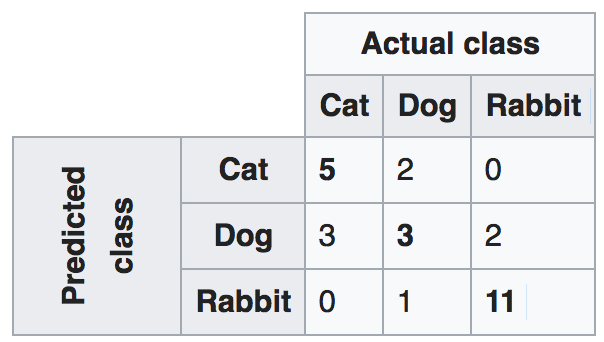

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

C:\Users\lavre\AppData\Local\Temp\ipykernel_9300\3386871327.py:37: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  confusion_matrix = np.zeros((10,10), np.int)


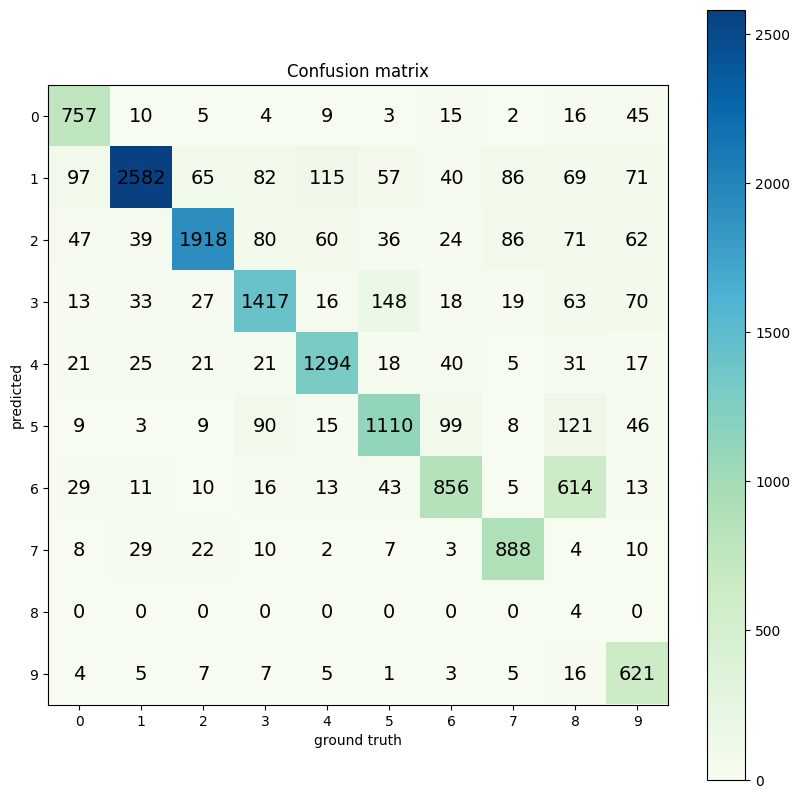

In [58]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    # TODO: Implement filling the prediction matrix
    for i, j in zip(predictions, ground_truth):
        confusion_matrix[i, j] += 1
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

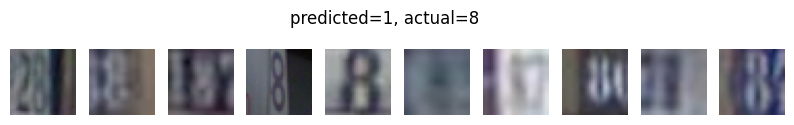

In [59]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    indexes = []
    for i, (predicted, gt) in enumerate(zip(predictions, groud_truth)):
        if predicted == predicted_class and gt == gt_class:
            indexes.append(i)
    visualize_images(val_indices[indexes], data, f'predicted={predicted_class}, actual={gt_class}')

# visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
# visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 8, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [51]:
nn_model = nn.Sequential(
        Flattener(),
        nn.Linear(3*32*32, 100),
        nn.ReLU(inplace=True),
        torch.nn.BatchNorm1d(100),
        nn.Linear(100, 100),
        nn.ReLU(inplace=True),
        torch.nn.BatchNorm1d(100),
        nn.Linear(100, 100),
        nn.ReLU(inplace=True),
        torch.nn.BatchNorm1d(100),
        nn.Linear(100, 10)
         )
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal(m.weight)
nn_model.apply(init_weights)

C:\Users\lavre\AppData\Local\Temp\ipykernel_9300\3132562731.py:16: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  torch.nn.init.kaiming_normal(m.weight)


Sequential(
  (0): Flattener()
  (1): Linear(in_features=3072, out_features=100, bias=True)
  (2): ReLU(inplace=True)
  (3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Linear(in_features=100, out_features=100, bias=True)
  (8): ReLU(inplace=True)
  (9): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Linear(in_features=100, out_features=10, bias=True)
)

In [52]:
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=10e-3, weight_decay=1e-1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

In [53]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer,scheduler, 20)

Average loss: 1.712124, Train accuracy: 0.457854, Val accuracy: 0.567743
Average loss: 1.446839, Train accuracy: 0.596782, Val accuracy: 0.579687
Average loss: 1.440881, Train accuracy: 0.611866, Val accuracy: 0.579483
Average loss: 1.440892, Train accuracy: 0.616968, Val accuracy: 0.628899
Average loss: 1.291753, Train accuracy: 0.699655, Val accuracy: 0.693878
Average loss: 1.251967, Train accuracy: 0.706071, Val accuracy: 0.710532
Average loss: 1.228278, Train accuracy: 0.708818, Val accuracy: 0.686984
Average loss: 1.209023, Train accuracy: 0.713528, Val accuracy: 0.685960
Average loss: 1.194896, Train accuracy: 0.716548, Val accuracy: 0.720702
Average loss: 1.107851, Train accuracy: 0.763420, Val accuracy: 0.764589
Average loss: 1.091743, Train accuracy: 0.771559, Val accuracy: 0.749915
Average loss: 1.080750, Train accuracy: 0.771883, Val accuracy: 0.761928
Average loss: 1.071849, Train accuracy: 0.773624, Val accuracy: 0.771824
Average loss: 1.062889, Train accuracy: 0.776047, V

In [45]:
nn_model = nn.Sequential(
        Flattener(),
        nn.Linear(3*32*32, 100),
        nn.ReLU(inplace=True),
        torch.nn.BatchNorm1d(100),
        nn.Linear(100, 100),
        nn.ReLU(inplace=True),
        torch.nn.BatchNorm1d(100),
        nn.Linear(100, 100),
        nn.ReLU(inplace=True),
        torch.nn.BatchNorm1d(100),
        nn.Linear(100, 10)
         )
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)
nn_model.apply(init_weights)
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=5e-3, weight_decay=1e-1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, scheduler, 20)

Average loss: 1.785013, Train accuracy: 0.422721, Val accuracy: 0.591086
Average loss: 1.382540, Train accuracy: 0.612992, Val accuracy: 0.650126
Average loss: 1.332085, Train accuracy: 0.648739, Val accuracy: 0.646577
Average loss: 1.320449, Train accuracy: 0.663601, Val accuracy: 0.685687
Average loss: 1.224559, Train accuracy: 0.725984, Val accuracy: 0.740291
Average loss: 1.192060, Train accuracy: 0.738525, Val accuracy: 0.743226
Average loss: 1.175658, Train accuracy: 0.742654, Val accuracy: 0.760699
Average loss: 1.161041, Train accuracy: 0.748063, Val accuracy: 0.740769
Average loss: 1.144772, Train accuracy: 0.754121, Val accuracy: 0.747389
Average loss: 1.089379, Train accuracy: 0.787684, Val accuracy: 0.787318
Average loss: 1.080437, Train accuracy: 0.791455, Val accuracy: 0.794690
Average loss: 1.073752, Train accuracy: 0.793810, Val accuracy: 0.794895
Average loss: 1.066708, Train accuracy: 0.799167, Val accuracy: 0.788547
Average loss: 1.060091, Train accuracy: 0.799253, V

In [49]:
nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3 * 32 * 32, 100),
    nn.ReLU(inplace=True),
    torch.nn.BatchNorm1d(100),
    nn.Linear(100, 100),
    nn.ReLU(inplace=True),
    torch.nn.BatchNorm1d(100),
    nn.Linear(100, 100),
    nn.ReLU(inplace=True),
    torch.nn.BatchNorm1d(100),
    nn.Linear(100, 10)
)


def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)


nn_model.apply(init_weights)
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=5e-3, weight_decay=1.2e-1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, scheduler, 21)

Average loss: 1.779222, Train accuracy: 0.431440, Val accuracy: 0.588834
Average loss: 1.432035, Train accuracy: 0.614323, Val accuracy: 0.645621
Average loss: 1.417920, Train accuracy: 0.636846, Val accuracy: 0.639615


KeyboardInterrupt: 

In [24]:
# for i in range(4):
#     lr = 10**np.random.uniform(-5, -1)
#     batch_size = int(10**np.random.uniform(1, 2))
#     weight_decay = np.random.uniform(0.05, 0.15)
#     gamma = np.random.uniform(0.95, 0.999)
#     print(lr, batch_size, weight_decay, gamma)
#     train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
#                                            sampler=train_sampler)
#     val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
#                                          sampler=val_sampler)
#     loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
#     optimizer = optim.SGD(nn_model.parameters(), lr=lr, weight_decay=weight_decay)
#     scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=gamma)
#     try:
#         loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, scheduler, 20)
#     except KeyboardInterrupt:
#         continue
for i in range(4):
    lr = 10**np.random.uniform(-5, -1)
    batch_size = int(10**np.random.uniform(1, 2))
    weight_decay = np.random.uniform(0.05, 0.15)
    gamma = np.random.uniform(0.1, 0.3)
    print(lr, batch_size, weight_decay, gamma)
    train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                           sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)
    loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
    optimizer = optim.SGD(nn_model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=gamma)
    try:
        loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, scheduler, 20)
    except KeyboardInterrupt:
        continue

0.006099020837006466 64 0.07043843436391414 0.23582344027940164
Average loss: 1.601507, Train accuracy: 0.495905, Val accuracy: 0.487544
Average loss: 1.471750, Train accuracy: 0.522114, Val accuracy: 0.486861
Average loss: 1.403462, Train accuracy: 0.551821, Val accuracy: 0.509112
0.03803038832545867 24 0.09481879795628184 0.2454440224327187
Average loss: 2.068096, Train accuracy: 0.290858, Val accuracy: 0.271859
Average loss: 2.095629, Train accuracy: 0.272020, Val accuracy: 0.205651
0.06155328657317037 19 0.13362815029823405 0.14348712064354066
Average loss: 2.255125, Train accuracy: 0.189366, Val accuracy: 0.188588
0.08903418391282791 20 0.10991314310785993 0.14295792213467257
Average loss: 2.252515, Train accuracy: 0.189366, Val accuracy: 0.188588
Average loss: 2.252617, Train accuracy: 0.189366, Val accuracy: 0.188588


In [54]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.7772
